In [1]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 32.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=8512c6a77691d68de3c3406bc988729112fe8b183378d48d58b62eda4906c5d5
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [2]:
%matplotlib inline

import glob
import os
import sys
import math
import copy
import joblib


import scipy as sp
from scipy import ndimage as ndi
from scipy.stats import fisher_exact
from statsmodels.stats.contingency_tables import mcnemar

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as cm

import sys; 
import numpy as np
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from typing import Optional, Union
from numpy import array, argmax, load

import warnings
warnings.filterwarnings("ignore")
Path="/content/drive/MyDrive/"

import cv2
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO
import numpy as np
import zipfile
import joblib
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


import skimage
from skimage.color import rgb2hed
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
from skimage.morphology import area_opening
from skimage.segmentation import mark_boundaries

import lime; from lime import lime_image

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
h5ad = pd.read_csv(Path+"h5ad_obs.csv", index_col=0)
gene_exp = pd.read_csv(Path+"gene_expression_visium.csv", index_col=0)
resnet_features = pd.read_csv(Path+"Resnet50_features.csv", index_col=0).iloc[:,1:]

h5ad['tile_tissue_mask_path'] = h5ad['tile_tissue_mask_path'].str.split('/', expand=True)[3].str[:-5]
h5ad = h5ad.set_index(['tile_tissue_mask_path'])

resnet_features.index = h5ad.index
resnet_features['dataset'] = resnet_features.index.to_series().str.split('-', expand=True)[0]

clf_resnet = joblib.load(Path+'resnet_block1_log_scaled.pkl')

In [4]:
#Resnet
X_test_resnet_FFPE =  resnet_features.loc[(resnet_features['dataset'] == "FFPE")]
X_test_resnet_block2 =  resnet_features.loc[(resnet_features['dataset'] == "block2")]


pred_resnet_FFPE = clf_resnet.predict(X_test_resnet_FFPE.iloc[:,:-1])
pred_resnet_block2 = clf_resnet.predict(X_test_resnet_block2.iloc[:,:-1])

In [5]:
gene_list_2 = ['CD74','CD24','CD63','CD81','CD151', 'COX6C','TP53','PABPC1','GNAS','B2M']
resnet_model1 = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")

def model_predict_gene(gene):
    i = gene_list_2.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model1.predict(tile1)
        prediction = clf_resnet.predict_proba(feature1)#[0]
        return prediction[i]#.reshape(-1,1)
    return combine_model_predict

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=0.01)
    thresh = skimage.filters.threshold_otsu(annotation_h)*0.7
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

def cell_summary(file_path,cell_type_input):
    cell_summary_tile = pd.read_csv(file_path)
    return cell_summary_tile.loc[(cell_summary_tile['cell_type'].isin(cell_type_input))]

def IOU(Ref_mask,Lime_mask):
    Lime_mask[Lime_mask == -1] = 0
    coordinate_x = np.array(round(Ref_mask['coordinate_x'])).astype('int64')
    coordinate_y = np.array(round(Ref_mask['coordinate_y'])).astype('int64')
    mask_initialised = np.array([[0]*299]*299)
    mask_initialised[coordinate_x,coordinate_y] = 1
    
    overlap = mask_initialised*Lime_mask # Logical AND
    return overlap.sum()/float(mask_initialised.sum())

def LIME_p_value(heatmap_cancer, heatmap_immune, cell_summary_Tumor, cell_summary_lymphocyte_stroma, cancer_mask, immune_mask):
    tumor_lime_score = []; immune_lime_score = []; tumor = []; immune = []

    for i in range(0,len(cell_summary_Tumor)):
      if cancer_mask[np.round(cell_summary_Tumor['coordinate_x'][i]).astype('int64')][np.round(cell_summary_Tumor['coordinate_y'][i]).astype('int64')]>0:
        tumor_lime_score.append(heatmap_cancer[np.round(cell_summary_Tumor['coordinate_x'][i]).astype('int64')][np.round(cell_summary_Tumor['coordinate_y'][i]).astype('int64')])
    for i in range(0,len(cell_summary_lymphocyte_stroma)):
      if immune_mask[np.round(cell_summary_lymphocyte_stroma['coordinate_x'][i]).astype('int64')][np.round(cell_summary_lymphocyte_stroma['coordinate_y'][i]).astype('int64')]>0:
        immune_lime_score.append(heatmap_immune[np.round(cell_summary_lymphocyte_stroma['coordinate_x'][i]).astype('int64')][np.round(cell_summary_lymphocyte_stroma['coordinate_y'][i]).astype('int64')])


    cell_summary_Tumor = np.ones((len(tumor_lime_score),), dtype=int)
    tumor = np.where(np.asarray(tumor_lime_score)==0, 0,1)

    cell_summary_lymphocyte_stroma = np.ones((len(immune_lime_score),), dtype=int)
    immune = np.where(np.asarray(immune_lime_score)==0, 0,1)

    cell_summary_Tumor_val = [np.sum(cell_summary_Tumor==0),np.sum(cell_summary_Tumor==1)]
    cell_summary_lymphocyte_stroma_val = [np.sum(cell_summary_lymphocyte_stroma==0),np.sum(cell_summary_lymphocyte_stroma==1)]

    tumor_val = [np.sum([tumor==0]),np.sum([tumor==1])]
    immune_val = [np.sum([immune==0]),np.sum([immune==1])]

    table_tumor = [[tumor_val[1],0],[np.sum([cell_summary_Tumor==1])-tumor_val[1],0]]
    p_value_tumor = mcnemar(table_tumor, exact=True)

    table_immune = [[immune_val[1],0],[np.sum([cell_summary_lymphocyte_stroma==1])-immune_val[1],0]]
    p_value_immune = mcnemar(table_immune, exact=True)

    oddsr_tumor, p_fisher_tumor = fisher_exact(table_tumor, alternative='two-sided')
    oddsr_immune, p_fisher_immune = fisher_exact(table_immune, alternative='two-sided')


    accuracy = ["Accuracy of Tumor Nuclei is:",accuracy_score(np.asarray(cell_summary_Tumor),np.asarray(tumor)),"Accuracy of Immune Nuclei is:",accuracy_score(np.asarray(cell_summary_lymphocyte_stroma),np.asarray(immune)),
              "Average Accuracy of LIME Model is:",(accuracy_score(np.asarray(cell_summary_Tumor),np.asarray(tumor))+accuracy_score(np.asarray(cell_summary_lymphocyte_stroma),np.asarray(immune)))/2]

    return accuracy#, p_value_tumor, p_value_immune, p_fisher_tumor, p_fisher_immune


explainer = lime_image.LimeImageExplainer()

94781440/94765736 [==============================] - 0s 0us/step


In [6]:
image1 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-7318-11963-299.jpeg'))
image2 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-10071-15247-299.jpeg'))
images = [image1, image2]

"""image_dir = glob.glob(os.path.join(Path, "LIME/*.jpeg"))
for image in image_dir:
  images.append(np.asarray(image_fun.load_img(image)))"""


immune_genes = ['CD74','CD24']
cancer_genes = ['COX6C','TP53']

immune_masks = []; immune_temp = []; heatmap_immune = []
cancer_masks = []; cancer_temp = []; heatmap_cancer = []
for n in range(0,len(images)):
  for i in range(0,len(immune_genes)):
    explanation_i = explainer.explain_instance(images[n], model_predict_gene(immune_genes[i]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
    temp_i, mask_i = explanation_i.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
    immune_masks.append(mask_i)
    immune_temp.append(temp_i)
    dict_heatmap_i = dict(explanation_i.local_exp[1])
    heatmap_i = np.vectorize(dict_heatmap_i.get)(explanation_i.segments)
    heatmap_immune.append(heatmap_i)
  for j in range(0,len(cancer_genes)):
    explanation_c = explainer.explain_instance(images[n], model_predict_gene(cancer_genes[j]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
    temp_c, mask_c = explanation_c.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
    cancer_masks.append(mask_c)
    cancer_temp.append(temp_c)
    dict_heatmap_c = dict(explanation_c.local_exp[1])
    heatmap_c = np.vectorize(dict_heatmap_c.get)(explanation_c.segments)
    heatmap_cancer.append(heatmap_c)

[array([[[111, 103, 188],
        [101,  93, 176],
        [ 92,  85, 165],
        ...,
        [231, 229, 242],
        [220, 218, 231],
        [212, 210, 224]],

       [[105,  98, 178],
        [ 97,  90, 168],
        [ 89,  82, 160],
        ...,
        [232, 230, 241],
        [223, 221, 232],
        [215, 213, 226]],

       [[ 99,  91, 166],
        [ 93,  85, 160],
        [ 90,  82, 155],
        ...,
        [242, 241, 249],
        [233, 232, 240],
        [226, 225, 233]],

       ...,

       [[189, 183, 211],
        [196, 190, 218],
        [187, 181, 209],
        ...,
        [180, 176, 199],
        [190, 186, 209],
        [203, 199, 222]],

       [[184, 176, 200],
        [198, 190, 213],
        [197, 189, 212],
        ...,
        [170, 166, 193],
        [177, 173, 200],
        [185, 181, 208]],

       [[178, 172, 186],
        [200, 194, 206],
        [208, 202, 214],
        ...,
        [172, 167, 197],
        [174, 169, 201],
        [176, 171, 203]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

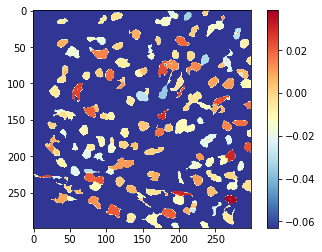

In [ ]:
plt.imshow(heatmap_cancer[3], alpha=1.0, cmap = 'RdYlBu_r', vmax=heatmap_cancer[3].max(), vmin=-heatmap_cancer[2].max())
plt.colorbar()

In [25]:
all_files = glob.glob(os.path.join(Path, "LIME/*.csv"))
all_files = [all_files[0],all_files[4]]

cell_summary_tumor = []
cell_summary_immune = []

for filename in all_files:
    histology_web_tool_csv = pd.read_csv(filename, index_col=None, header=0)
    cell_summary_tumor.append(histology_web_tool_csv.loc[(histology_web_tool_csv['cell_type'].isin(["Tumor"]))].reset_index())
    cell_summary_immune.append(histology_web_tool_csv.loc[(histology_web_tool_csv['cell_type'].isin(["Stroma","Lymphocyte"]))].reset_index())


In [50]:
len()

2

In [29]:
immune_score = []
start_j=0; start_i = 0; iter = -1
for j in range(start_j,len(cell_summary_immune)):
  counter = 0;
  for i in range(start_i,len(immune_masks)):
    iter+=1
    counter+=1
    i=iter
    #print("iteration",iter)
    #print("count",counter)
    #print("j",l1[j])
    #print("i",l2[i])
    immune_score.append(IOU(cell_summary_immune[j],immune_masks[i]))
    if counter == len(immune_genes):
      break

tumor_score = []
start_j=0; start_i = 0; iter = -1
for j in range(start_j,len(cell_summary_tumor)):
  counter = 0;
  for i in range(start_i,len(cancer_masks)):
    iter+=1
    counter+=1
    i=iter
    tumor_score.append(IOU(cell_summary_tumor[j],cancer_masks[i]))
    if counter == len(cancer_genes):
      break

In [39]:
heatmap_cancer_gene_total = np.add.reduceat(heatmap_cancer, np.arange(0, len(heatmap_cancer), len(cancer_genes)))
heatmap_cancer_gene_total[heatmap_cancer_gene_total<0]=0

heatmap_immune_gene_total = np.add.reduceat(heatmap_immune, np.arange(0, len(heatmap_immune), len(immune_genes)))
heatmap_immune_gene_total[heatmap_immune_gene_total<0]=0

immune_masks_combined = np.add.reduceat(immune_masks, np.arange(0, len(immune_masks), len(immune_genes)))/len(immune_genes)
cancer_masks_combined = np.add.reduceat(cancer_masks, np.arange(0, len(cancer_masks), len(cancer_genes)))/len(cancer_genes)

accuracy = []
for i in range(0,len(images)):
  heatmap_cancer_gene_total_i = heatmap_cancer_gene_total[i]
  heatmap_immune_gene_total_i = heatmap_immune_gene_total[i]
  cell_summary_tumor_i = cell_summary_tumor[i]
  cell_summary_immune_i = cell_summary_immune[i]
  cancer_masks_combined_i = cancer_masks_combined[i]
  immune_masks_combined_i = immune_masks_combined[i]
  accuracy_lime = LIME_p_value(heatmap_cancer_gene_total_i, heatmap_immune_gene_total_i, cell_summary_tumor_i, cell_summary_immune_i, cancer_masks_combined_i, immune_masks_combined_i)
  accuracy.append(accuracy_lime)

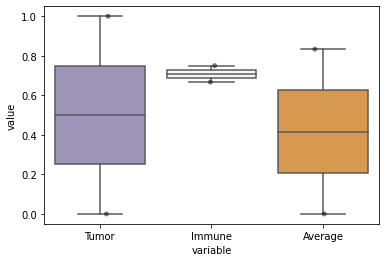

In [49]:
accuracy_tumor = []; accuracy_immune = []; accuracy_average = []
for i in range(0,len(accuracy)):
  accuracy_tumor.append(accuracy[i][1])
  accuracy_immune.append(accuracy[i][3])
  accuracy_average.append(accuracy[i][5])

data = [accuracy_tumor,accuracy_immune,accuracy_average]
LIME_accuracy_df = pd.DataFrame(data, index = ['Tumor', 'Immune', 'Average']).T
LIME_accuracy_df = pd.melt(LIME_accuracy_df)
LIME_accuracy_df.fillna(0,inplace=True)

sns.boxplot(x="variable",y='value',data=LIME_accuracy_df, palette="PuOr_r")
sns.stripplot(x="variable",y='value',data=LIME_accuracy_df, color = 'black',alpha = 0.5)